# Set up Google Colab

This means mounting drive and importing

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Lab/Grain-U-Net'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))
sys.path.append('/content/drive/MyDrive/{}/src'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

!pip install -q plantcv
!pip install -e .

In [ ]:
%load_ext autoreload
%autoreload 2
%aimport -tensorflow

# Train

Currently we have two ways of doing this, one with a keras Sequence and one with ImageDataGenerator. It isn't obvious which of these is better, 

the Sequence is:
- Less opaque
- Easier to debug (for me at least)
- Pretty straight forward and customizable

And the ImageDataGenerator is:
- Fewer lines (sort of)
- It has built in data augmentation
- Faster (since its all written by pros)
- Doesn't really seem super well suited to like semantic segmentation, but its probably fine

So for now, I'm spending most of my time with the Sequence approach, but both are good

## Train With Sequence

**Importing the names of all the files we want to train with**

In [15]:
from pathlib import Path
import numpy as np

train_dir = Path('data/train_atarashii_256')

input_names = list(train_dir.glob('**/image/*.png'))
label_names = list(train_dir.glob('**/label/*.png'))

print(f"Found {len(input_names)} samples and {len(label_names)} tracings")

Found 675 samples and 675 tracings


**Making Sequence**

In [101]:
from src import GrainSequence
import random

validation_samples = 30
batch_size = 5

random.Random(1337).shuffle(input_names)
random.Random(1337).shuffle(label_names)

train_input = input_names[:-validation_samples]
train_label = label_names[:-validation_samples]
train_gen = GrainSequence(batch_size, (256,256), train_input, train_label)

valid_input = input_names[-validation_samples:]
valid_label = label_names[-validation_samples:]
valid_gen = GrainSequence(batch_size, (256,256), valid_input, valid_label)

print(f"Training set size: {len(train_input)}, {len(train_gen)} batches")
print(f"Validation set size: {len(valid_input)}, {len(valid_gen)} batches")

[print(f'{i}\n{l}\n\n') for (i, l) in zip(train_input, train_label)]

Training set size: 645, 129 batches
Validation set size: 30, 6 batches
data/train_atarashii_256/1hr2753/image/1hr2751_1_c4.png
data/train_atarashii_256/1hr2753/label/1hr2751_1_c4.png


data/train_atarashii_256/2hr2349/image/2hr_2349_3_c3.png
data/train_atarashii_256/2hr2349/label/2hr_2349_3_c3.png


data/train_atarashii_256/train_nouveaux_256/image/71.png
data/train_atarashii_256/train_nouveaux_256/label/71.png


data/train_atarashii_256/4hr2414/image/4hr2414_1_c1.png
data/train_atarashii_256/4hr2414/label/4hr2414_1_c1.png


data/train_atarashii_256/2hr2331/image/2hr2331_2_c6.png
data/train_atarashii_256/2hr2331/label/2hr2331_2_c6.png


data/train_atarashii_256/train_nouveaux_256/image/156.png
data/train_atarashii_256/train_nouveaux_256/label/156.png


data/train_atarashii_256/2hr2364/image/2hr2364_3_c5.png
data/train_atarashii_256/2hr2364/label/2hr2364_3_c5.png


data/train_atarashii_256/4hr2465/image/4hr2418_2_c2.png
data/train_atarashii_256/4hr2465/label/4hr2418_2_c2.png


data/trai

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [76]:
from src import get_unet
from tensorflow import keras

model = get_unet(input_size = (256, 256, 1))
model_checkpoint = keras.callbacks.ModelCheckpoint('unet_grain.hdf5', monitor='loss', verbose=1, save_best_only=False)
history = model.fit(
    train_gen, 
    steps_per_epoch=len(train_gen), 
    epochs=30, 
    callbacks=[model_checkpoint], 
     validation_data=valid_gen
)

Epoch 1/30


KeyboardInterrupt: 

In [ ]:
# import matplotlib.pyplot as plt

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

plt.figure(figsize=(10,5), facecolor='White')

plt.title("Loss With Pre Augmentation and Full Dataset (b5, s59)")
plt.xlabel("Epochs")
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.legend()
plt.show()

# N-Channel Testing

So the idea is that we'll use this file structure and point to the test_dir
````
test_dir
├── FOV1
│   ├── predict
│   │   ├── img1.png
│   │   ├── img2.png
│   │   ├── img3.png
│   │   └── img4.png
│   ├── raw
│   │   ├── img1.png
│   │   ├── img2.png
│   │   ├── img3.png
│   │   └── img4.png
│   └── unet_skel.png
├── FOV2
│   ├── predict
│   │   ├── img1.png
│   │   └── img2.png
│   ├── raw
│   │   ├── img1.png
│   │   └── img2.png
│   └── unet_skel.png
└── FOV3
    ├── predict
    │   ├── img1.png
    │   ├── img2.png
    │   └── img3.png
    ├── raw
    │   ├── img1.png
    │   ├── img2.png
    │   └── img3.png
    └── unet_skel.png
````

[PosixPath('data/test_Cu/02_Cu80_AT400_Selected_aligned/raw/005_0.tif'), PosixPath('data/test_Cu/02_Cu80_AT400_Selected_aligned/raw/005_-2.tif'), PosixPath('data/test_Cu/02_Cu80_AT400_Selected_aligned/raw/005_2.tif')]


2022-04-25 03:50:26.502806: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/jamie/Documents/Lab/graingrowth/grain-unet/venv/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.


3/3 [==============================] - 56s 19s/step
made dir

Saving to data/test_Cu/02_Cu80_AT400_Selected_aligned/predict/005_0.png
Min: 110.81732940673828, Max: 255.0, Shape: (768, 768)


/Users/jamie/Documents/Lab/graingrowth/grain-unet/venv/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.


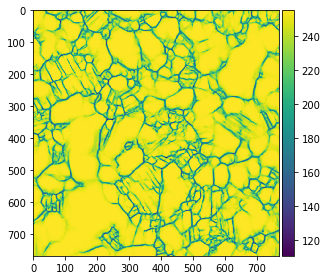


Saving to data/test_Cu/02_Cu80_AT400_Selected_aligned/predict/005_-2.png
Min: 115.6367416381836, Max: 254.99951171875, Shape: (768, 768)

Saving to data/test_Cu/02_Cu80_AT400_Selected_aligned/predict/005_2.png
Min: 111.53450012207031, Max: 254.99942016601562, Shape: (768, 768)


In [1]:
import os
from pathlib import Path
from skimage import io
from src import get_unet, image_generator
import numpy as np

target_size = (768,768)
test_dir = Path('data/test_Cu/')

paths = list(test_dir.glob('*/raw/*'))
print(f'{len(paths)} images found')
img_gen = image_generator(paths, target_size=target_size)

model = get_unet(input_size=(target_size + (1,)))
model.load_weights("results/nouveaux256_aug_b5-s53-e66.hdf5")
results = 255 * model.predict(img_gen, steps=len(paths), verbose=1)

assert len(paths) == len(results), 'Not all the files ran'

for ind, path in enumerate(paths): 
    save_dir = path.parents[1] / 'predict'
    if not save_dir.is_dir():
        print('made dir')
        save_dir.mkdir()
        
    save_path = save_dir / path.with_suffix('.png').name
    result = results[ind, :, :, 0]
    
    print(f"\nSaving to {save_path}")
    print(f"Min: {np.min(result)}, Max: {np.max(result)}, Shape: {result.shape}")
    io.imsave(save_path, result.astype('uint8'))
    if ind == 0:
        io.imshow(result)
        io.show()

# Post Processing

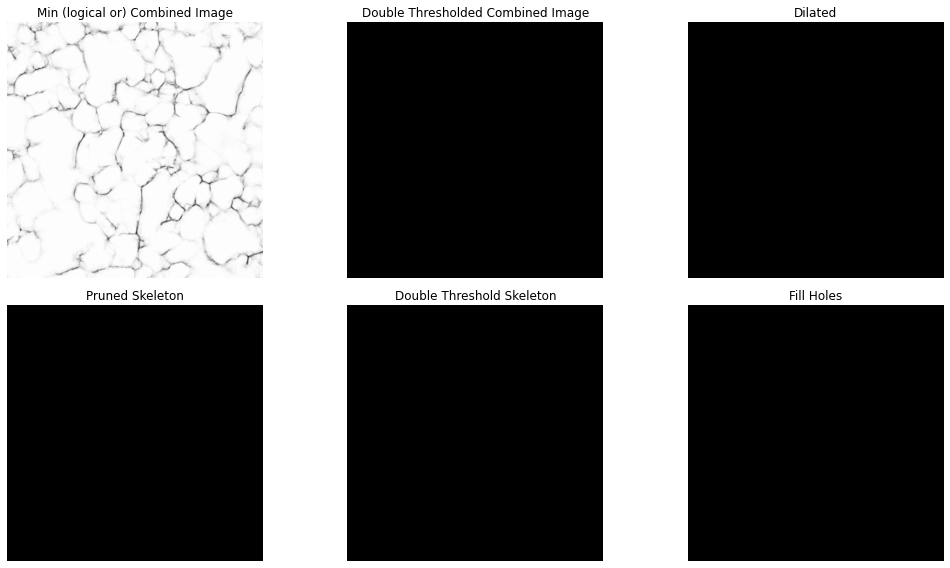

Saving to: data/test_Cu/02_Cu80_AT400_Selected_aligned/unet_skel.png


In [37]:
from pathlib import Path
from skimage import io
from src import post_process

if 'test_dir' not in locals():
    test_dir = Path('data/test_Cu/')

process_args = {
        'compilation': 'max',
        'liberal_thresh': 195,
        'conservative_thresh': 135,
        'invert_double_thresh': True,
        'n_dilations': 2,
        'min_grain_area': 300,
        'prune_size': 100,
        'out_dict': True
}
    
for FOV in test_dir.glob('*'):
    if not (FOV / 'predict').is_dir():
        continue
    
    imgs = np.array([])
    for fname in FOV.glob("predict/*.png"):
        if not fname.is_file(): continue
        
        img = io.imread(fname)
        if len(img.shape) > 2:
            img = img[:,:,0]
            
        if len(imgs) == 0:
            imgs = img
        else:
            imgs = np.dstack((imgs,img))
               
    data = post_process(imgs, **process_args)
    
    from matplotlib import pyplot as plt
    from src.visual_tools import *
    fig, axes = plt.subplots(2, 3, figsize=(15,8))

    for ax in axes.flatten():
        ax.set_axis_off()

    sub_plot(axes[0,0], data['compiled'], title='Min (logical or) Combined Image')
    sub_plot(axes[0,1], data['double_thresh'], title='Double Thresholded Combined Image')
    sub_plot(axes[0,2], data['dilated'], title='Dilated')
    sub_plot(axes[1,2], data['closed'], title='Fill Holes')

    sub_plot(axes[1,1], data['skeleton'], title='Double Threshold Skeleton')
    sub_plot(axes[1,0], data['pruned_skeleton'], title='Pruned Skeleton')

    fig.tight_layout()
    plt.show()
    plt.close()
    
    io.imsave(FOV / 'unet_max_compiled.png', data['compiled'].astype('uint8'))
    print(f'Saving to: {FOV / "unet_skel.png"}')

## Overlay 

In [ ]:
from skimage import io, transform
import numpy as np
import os

if 'test_n' not in locals():
    test_n = 1
    test_dir = 'data/test/'

for i in range(test_n):
    i = i + 1
    raw_img = io.imread(f'{test_dir}0{i}.png')
    sk_img = io.imread(f'{test_dir}{i}_processed.png')
    sk_img = 255 * transform.resize(sk_img, raw_img.shape, anti_aliasing=False)
    fusion_img = np.zeros((raw_img.shape[0], raw_img.shape[1], 3), dtype=int)
    fusion_img[:, :, 0] = raw_img
    fusion_img[:, :, 1] = raw_img
    fusion_img[:, :, 2] = raw_img
    fusion_img[sk_img > 0, 0] = 255
    if os.path.isfile(f'{test_dir}key/{i}.png'):
        ht_img = io.imread(f'{test_dir}key/{i}.png')
        ht_img = 255 - (255 * transform.resize(ht_img, raw_img.shape, anti_aliasing=False))
        fusion_img[ht_img > 0, 1] = 255
#        io.imshow(fusion_img)
#        io.show()

    io.imsave(f'{test_dir}{i}_overlaid.png', fusion_img.astype('uint8')) 


# Model Evaluation Tools

## Intersection Over Union (IOU)
This test should find what percent of the predicted grain boundary (pred) matched the actual hand traced boundary (test)

`iou_test.find_iou(pred, ref)` 
This function finds the mean IOU between `pred` and `ref`. It does this by matching each grain in a traced (`ref`) image with a grain in the corresponding predicted (`pred`) image and calculating the Jaccard similarity index between them. It then takes the mean of all these Jaccard indicies to find the final mean iou of an image.

In [ ]:
from skimage import io, transform
import numpy as np
from src.analysis import find_iou
import importlib, os
importlib.reload(iou_test)

if 'test_n' in locals():
    test_dir = 'data/test/'
    traced_dir = 'data/test/key/'

traced_dir = test_dir + 'key/'
traced_names = np.sort(os.listdir(traced_dir))
traced = np.char.strip(traced_names, '.png')

results = np.array([], dtype=np.float64)

for key in traced:
    ml_img = io.imread(test_dir + key + '_processed.png') / 255
    ml_img = 1 - ml_img
#    ml_img = io.imread(test_dir + key + '_predict.png') / 255
    key_img = transform.resize(io.imread(traced_dir + key + '.png'), ml_img.shape)
    key_img = key_img > 0.9
    
    iou = find_iou(ml_img, key_img, verbose=False)
    results = np.append(results, iou)
    print(f' - img {key} \t Mean IOU: {iou}')
    
print(f'\nMean Mean IOU = {np.mean(results)}\nMedian Mean IOU = {np.median(results)}\n\n')
print(f'Max Mean IOU = {np.max(results)}, Min Mean IOU = {np.min(results)}')


## Chi2

In [ ]:
from chi2test import find_chi2
from skimage import io, transform
import os
import numpy as np
import time

test_dir = 'data/test/'
traced_dir = 'data/test/key/'
traced_names = np.sort(os.listdir(traced_dir))
traced = np.char.strip(traced_names, '.png')

chi2_dtype = [('img', (np.str_, 10)), ('chi2', np.float64), ('avg_chi2', np.float64)]
results = np.array([], dtype=chi2_dtype)

for key in traced:
    ml_img = io.imread(test_dir + key + '_processed.png')
    key_img = transform.resize(io.imread(traced_dir + key + '.png'), ml_img.shape)

    if np.min(key_img) != 0 or np.max(key_img) != 255:
        key_img -= np.min(key_img)
        key_img = np.round(key_img * (255 / np.max(key_img)))
    key_img = np.max(key_img) - key_img
    
    result = find_chi2(ml_img, key_img, out_dict=True)
    results = np.append(results, \
                np.array([(key, result["chi2"], result["avg_chi2"])], dtype=chi2_dtype))
    print(f'- img: {key} \t chi2: {result["chi2"]} \t avg_chi2: {result["avg_chi2"]} \t median_r2: {result["median_r2"]}')

print(f'\nAverage chi2: {np.mean(results["chi2"])}\nAverage avg_chi2: {np.mean(results["avg_chi2"])}\nMedian chi2: {np.median(results["chi2"])}')
print(f'Max chi2: {np.max(results["chi2"])}\nMin chi2: {np.min(results["chi2"])}')

## Chi2 Alignment

In [ ]:
from chi2test import *
from skimage import io, transform
import numpy as np

traced_n = 13
traced_dir = 'data/test/key/'

ml_img = io.imread('data/test/5_processed.png')
key_img = transform.resize(io.imread('data/test/key/5.png'), ml_img.shape)

if np.min(ml_img) != 0 or np.max(ml_img) != 255:
    ml_img -= np.min(ml_img)
    ml_img = np.round(ml_img * (255 / np.max(ml_img)))
        
if np.min(key_img) != 0 or np.max(key_img) != 255:
    key_img -= np.min(key_img)
    key_img = np.round(key_img * (255 / np.max(key_img)))
    
key_img = 255 - key_img

io.imshow(key_img)
io.show()

io.imshow(ml_img)
io.show()

results = chi2_align(ml_img, key_img)

print(results)

print(find_chi2(ml_img, key_img))

offset_x = int(results["x"])
offset_y = int(results["y"])
fuse_size = np.maximum(key_img.shape, ml_img.shape)
fuse_size[0] += 2 * abs(offset_x) + 2
fuse_size[1] += 2 * abs(offset_y) + 2

def fuse(out, img, offset_x=0, offset_y=0):
    buf_x = out.shape[0] - img.shape[0]
    buf_y = out.shape[1] - img.shape[1]
    img = np.round(img * (255 / np.max(img)))
    x_low = buf_x//2 + offset_x
    y_low = buf_y//2 + offset_y
    x_high = -buf_x//2 + offset_x
    y_high = -buf_y//2 + offset_y
    print(x_low, y_low, x_high, y_high)
    if (x_high > -1):
        x_high = x_low + img.shape[0]
    if (y_high > -1):
        y_high = y_low + img.shape[1]
    out[x_low : x_high, y_low : y_high] = img

fuse_img = np.zeros((fuse_size[0], fuse_size[1], 3), dtype=int)
print(fuse_img.shape)
fuse(fuse_img[:,:,0], ml_img, offset_x, offset_y)
print(fuse_img.shape)
fuse(fuse_img[:,:,1], key_img)

io.imshow(fuse_img)
io.show()
